In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GroupShuffleSplit 

import glob
import sys
import os
import math
import gc
import sys
import sklearn
import scipy

print("TensorFlow version:", tf.__version__)
print(f'Python V{sys.version}')

TensorFlow version: 2.13.0
Python V3.10.19 (main, Oct 10 2025, 08:52:10) [GCC 13.3.0]


In [13]:

TRAIN_CSV = '../asl-signs/train.csv'
train = pd.read_csv(TRAIN_CSV)
train['sign_ord'] = train['sign'].astype('category').cat.codes

SIGN2ORD = train[['sign', 'sign_ord']].set_index('sign').squeeze().to_dict()
ORD2SIGN = train[['sign_ord', 'sign']].set_index('sign_ord').squeeze().to_dict()

print("Dataset shape:", train.shape)
print("Unique signs:", train['sign'].nunique())

Dataset shape: (94477, 5)
Unique signs: 250


# Quick look at the data

In [14]:
print(train.head())


                                            path  participant_id  sequence_id  \
0  train_landmark_files/26734/1000035562.parquet           26734   1000035562   
1  train_landmark_files/28656/1000106739.parquet           28656   1000106739   
2   train_landmark_files/16069/100015657.parquet           16069    100015657   
3  train_landmark_files/25571/1000210073.parquet           25571   1000210073   
4  train_landmark_files/62590/1000240708.parquet           62590   1000240708   

    sign  sign_ord  
0   blow        25  
1   wait       232  
2  cloud        48  
3   bird        23  
4   owie       164  


In [15]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94477 entries, 0 to 94476
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            94477 non-null  object
 1   participant_id  94477 non-null  int64 
 2   sequence_id     94477 non-null  int64 
 3   sign            94477 non-null  object
 4   sign_ord        94477 non-null  int16 
dtypes: int16(1), int64(2), object(2)
memory usage: 3.1+ MB
None


In [16]:
print(train.describe(include='all'))

                                                 path  participant_id  \
count                                           94477    94477.000000   
unique                                          94477             NaN   
top     train_landmark_files/26734/1000035562.parquet             NaN   
freq                                                1             NaN   
mean                                              NaN    33678.632366   
std                                               NaN    16138.124387   
min                                               NaN     2044.000000   
25%                                               NaN    25571.000000   
50%                                               NaN    32319.000000   
75%                                               NaN    49445.000000   
max                                               NaN    62590.000000   

         sequence_id    sign      sign_ord  
count   9.447700e+04   94477  94477.000000  
unique           NaN     250     

# Distribution of labels that is the signs 

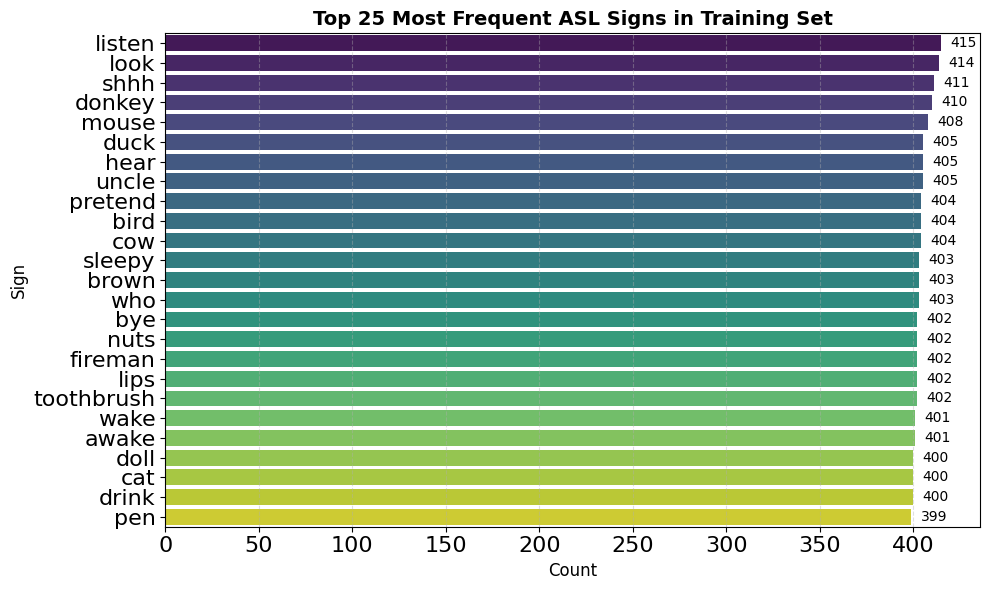

In [19]:
# Number of top 25 classes
TOP_N = 25  


top_signs = train['sign'].value_counts().head(TOP_N)

plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_signs.values,
    y=top_signs.index,
    palette='viridis'
)


for i, v in enumerate(top_signs.values):
    plt.text(v + 5, i, str(v), color='black', va='center', fontsize=10)

plt.title(f'Top {TOP_N} Most Frequent ASL Signs in Training Set', fontsize=14, weight='bold')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Sign', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Plot ordered by ordinal codes

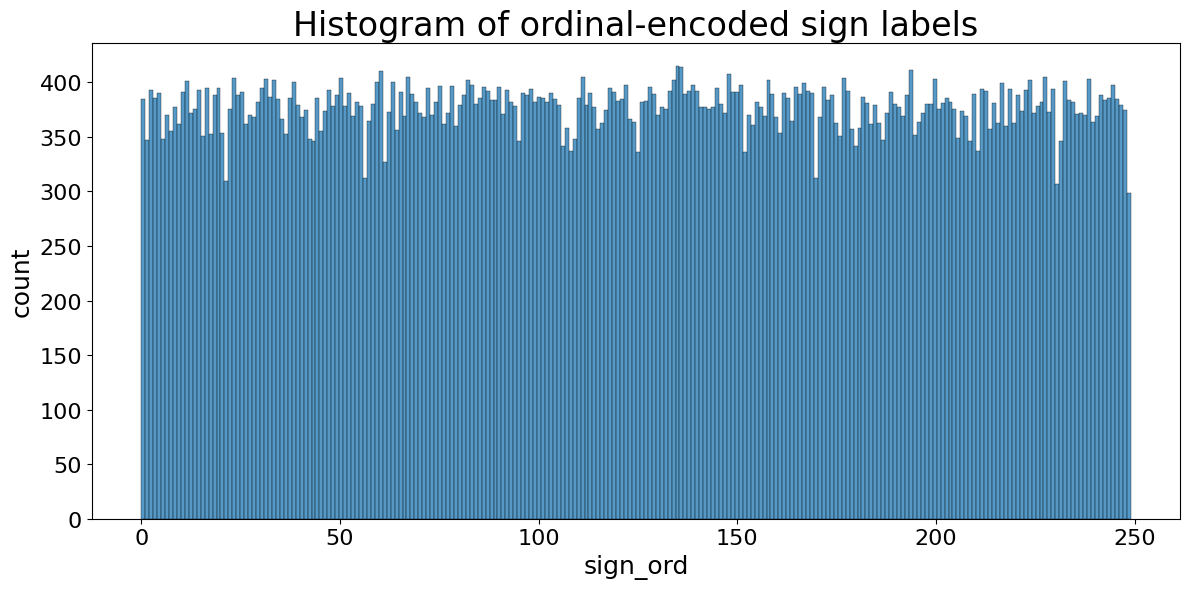

In [20]:
plt.figure(figsize=(12,6))
sns.histplot(data=train, x='sign_ord', bins=train['sign_ord'].nunique(), kde=False)
plt.title('Histogram of ordinal-encoded sign labels')
plt.xlabel('sign_ord')
plt.ylabel('count')
plt.tight_layout()
plt.show()

#   Correlation and relationships (if numeric columns exist)

In [23]:
numeric_cols = train.select_dtypes(include=np.number).columns.tolist()
print("Numeric columns:", numeric_cols)

Numeric columns: ['participant_id', 'sequence_id', 'sign_ord']


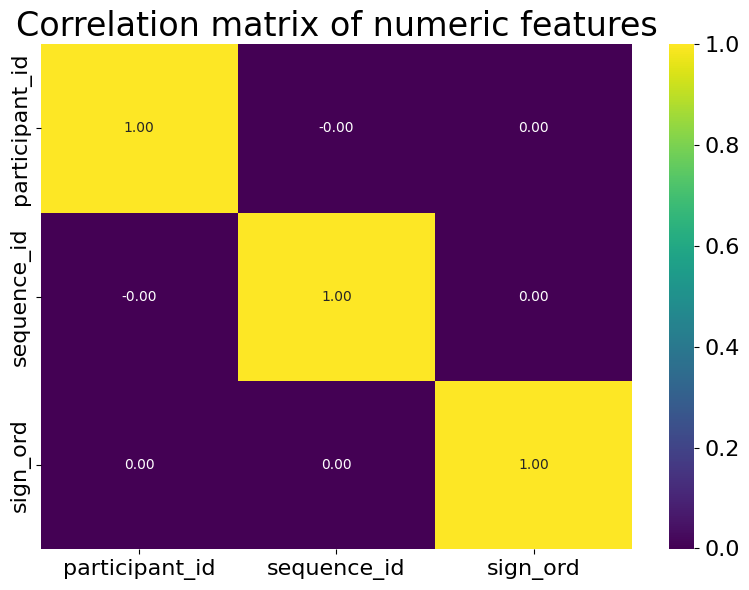

In [29]:
if len(numeric_cols) > 1:
    plt.figure(figsize=(8,6))
    corr = train[numeric_cols].corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='viridis')
    plt.title('Correlation matrix of numeric features')
    plt.tight_layout()
    plt.show()

# Missing values check

In [32]:
missing = train.isnull().sum().sort_values(ascending=False)
print("Missing values in each column:\n", missing)

Missing values in each column:
 path              0
participant_id    0
sequence_id       0
sign              0
sign_ord          0
dtype: int64


# Mean , Median and std 

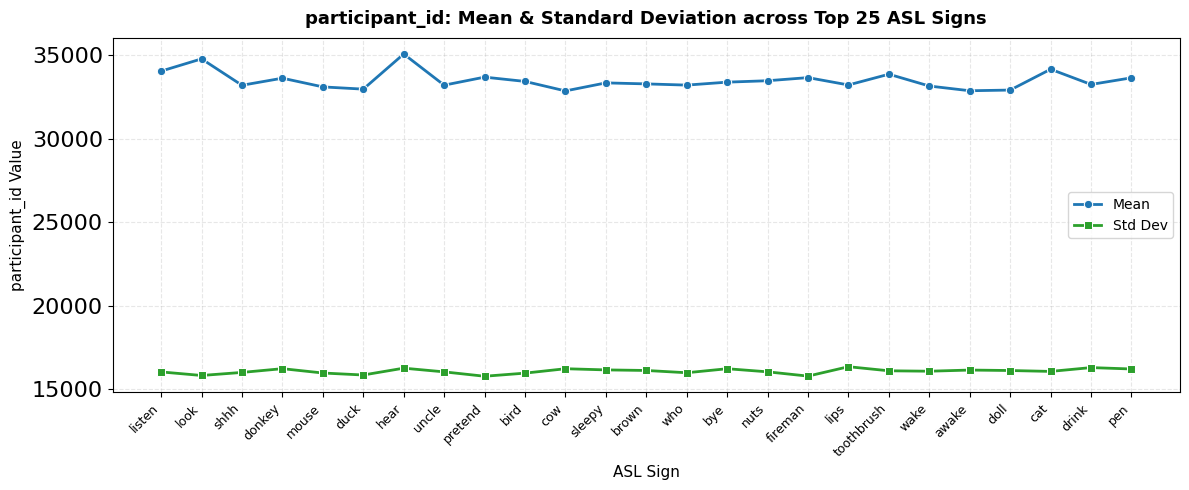

 For 'participant_id': Signs with more variability show higher std. Overall std-of-mean across signs ≈ 516.097


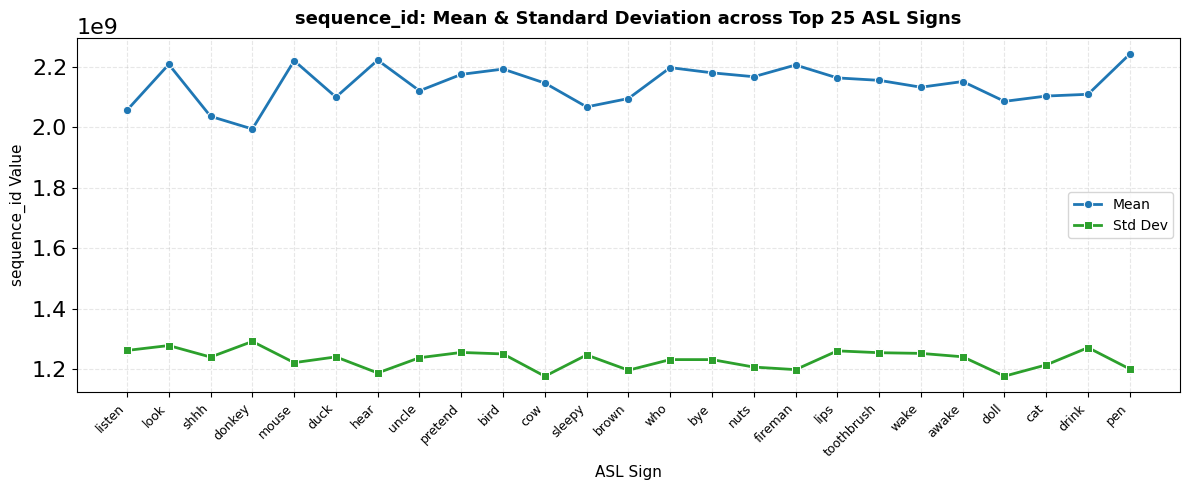

 For 'sequence_id': Signs with more variability show higher std. Overall std-of-mean across signs ≈ 62163434.265


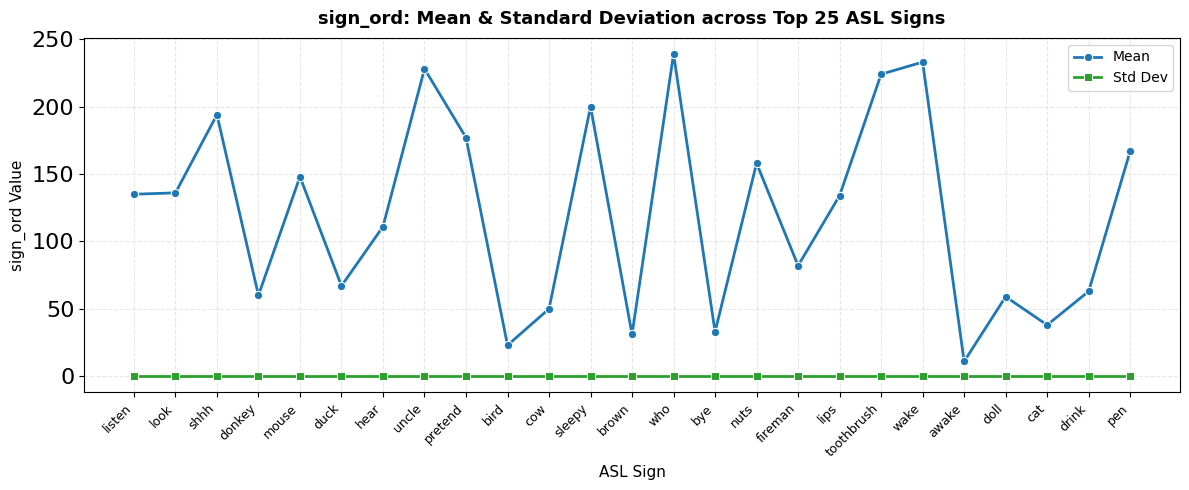

 For 'sign_ord': Signs with more variability show higher std. Overall std-of-mean across signs ≈ 72.313


In [38]:

num_cols = train.select_dtypes(include=np.number).columns.tolist()

if len(num_cols) > 1:
   
    mean_per_sign = train.groupby('sign')[num_cols].mean()
    std_per_sign  = train.groupby('sign')[num_cols].std()

    
    top_signs = train['sign'].value_counts().head(25).index
    mean_top = mean_per_sign.loc[top_signs]
    std_top = std_per_sign.loc[top_signs]

    for col in num_cols[:3]: 
        plt.figure(figsize=(12, 5))
        
        
        sns.lineplot(
            data=mean_top, 
            x=mean_top.index, 
            y=col, 
            label='Mean', 
            marker='o', 
            linewidth=2, 
            color='#1f77b4'
        )
        sns.lineplot(
            data=std_top, 
            x=std_top.index, 
            y=col, 
            label='Std Dev', 
            marker='s', 
            linewidth=2, 
            color='#2ca02c'
        )

        plt.title(f"{col}: Mean & Standard Deviation across Top 25 ASL Signs", fontsize=13, weight='bold', pad=10)
        plt.xticks(rotation=45, ha='right', fontsize=9)
        plt.xlabel("ASL Sign", fontsize=11)
        plt.ylabel(f"{col} Value", fontsize=11)
        plt.grid(alpha=0.3, linestyle='--')
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Relation insight text
        corr_val = train[[col, 'sign']].groupby('sign')[col].mean().std()
        print(f" For '{col}': Signs with more variability show higher std. Overall std-of-mean across signs ≈ {corr_val:.3f}")


# Video Statistics

In [41]:
# Handle missing Kaggle environment variable
IS_INTERACTIVE = os.environ.get("KAGGLE_KERNEL_RUN_TYPE", "") == "Interactive"

# Config flags
PREPROCESS_DATA = False
TRAIN_MODEL = True
USE_VAL = False

N_ROWS = 543
N_DIMS = 3
DIM_NAMES = ['x', 'y', 'z']
SEED = 42
NUM_CLASSES = 250
VERBOSE = 1 if IS_INTERACTIVE else 2

INPUT_SIZE = 64
BATCH_ALL_SIGNS_N = 4
BATCH_SIZE = 256
N_EPOCHS = 100
LR_MAX = 1e-3
N_WARMUP_EPOCHS = 0
WD_RATIO = 0.05
MASK_VAL = 4237

In [46]:
DATA_DIR = "../asl-signs"  # change this if your folder differs

# Read train.csv
train_csv_path = os.path.join(DATA_DIR, "train.csv")
train = pd.read_csv(train_csv_path).sample(int(5e3), random_state=SEED)

print(f"N_SAMPLES: {len(train)}")

N_SAMPLES: 5000


In [47]:
def get_file_path(path):
    return os.path.join(DATA_DIR, path)

train["file_path"] = train["path"].apply(get_file_path)

# Add ordinal encoding for signs
train["sign_ord"] = train["sign"].astype("category").cat.codes

SIGN2ORD = train[["sign", "sign_ord"]].set_index("sign").squeeze().to_dict()
ORD2SIGN = train[["sign_ord", "sign"]].set_index("sign_ord").squeeze().to_dict()

display(train.head(5))

,path,participant_id,sequence_id,sign,file_path,sign_ord
56533,train_landmark_files/28656/3311214787.parquet,28656,3311214787,sticky,../asl-signs/train_landmark_files/28656/331121...,206
63119,train_landmark_files/53618/3588192588.parquet,53618,3588192588,before,../asl-signs/train_landmark_files/53618/358819...,20
8760,train_landmark_files/4718/1363575346.parquet,4718,1363575346,pretty,../asl-signs/train_landmark_files/4718/1363575...,178
93310,train_landmark_files/37779/951199059.parquet,37779,951199059,hen,../asl-signs/train_landmark_files/37779/951199...,114
44842,train_landmark_files/36257/283190141.parquet,36257,283190141,tomorrow,../asl-signs/train_landmark_files/36257/283190...,221


In [48]:
N = int(1e3) if (IS_INTERACTIVE or not PREPROCESS_DATA) else int(10e3)
N_UNIQUE_FRAMES = np.zeros(N, dtype=np.uint16)
N_MISSING_FRAMES = np.zeros(N, dtype=np.uint16)
MAX_FRAME = np.zeros(N, dtype=np.uint16)

PERCENTILES = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 0.999]

for idx, file_path in enumerate(tqdm(train["file_path"].sample(N, random_state=SEED))):
    df = pd.read_parquet(file_path)
    N_UNIQUE_FRAMES[idx] = df["frame"].nunique()
    N_MISSING_FRAMES[idx] = (df["frame"].max() - df["frame"].min()) - df["frame"].nunique() + 1
    MAX_FRAME[idx] = df["frame"].max()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 117.06it/s]


In [51]:
# Number of unique frames in each video
display(pd.Series(N_UNIQUE_FRAMES).describe(percentiles=PERCENTILES).to_frame('N_UNIQUE_FRAMES'))

,N_UNIQUE_FRAMES
count,1000.000000
mean,37.676000
std,46.188184
min,4.000000
1%,6.000000
5%,6.000000
25%,11.000000
50%,21.000000
75%,43.000000
95%,139.050000


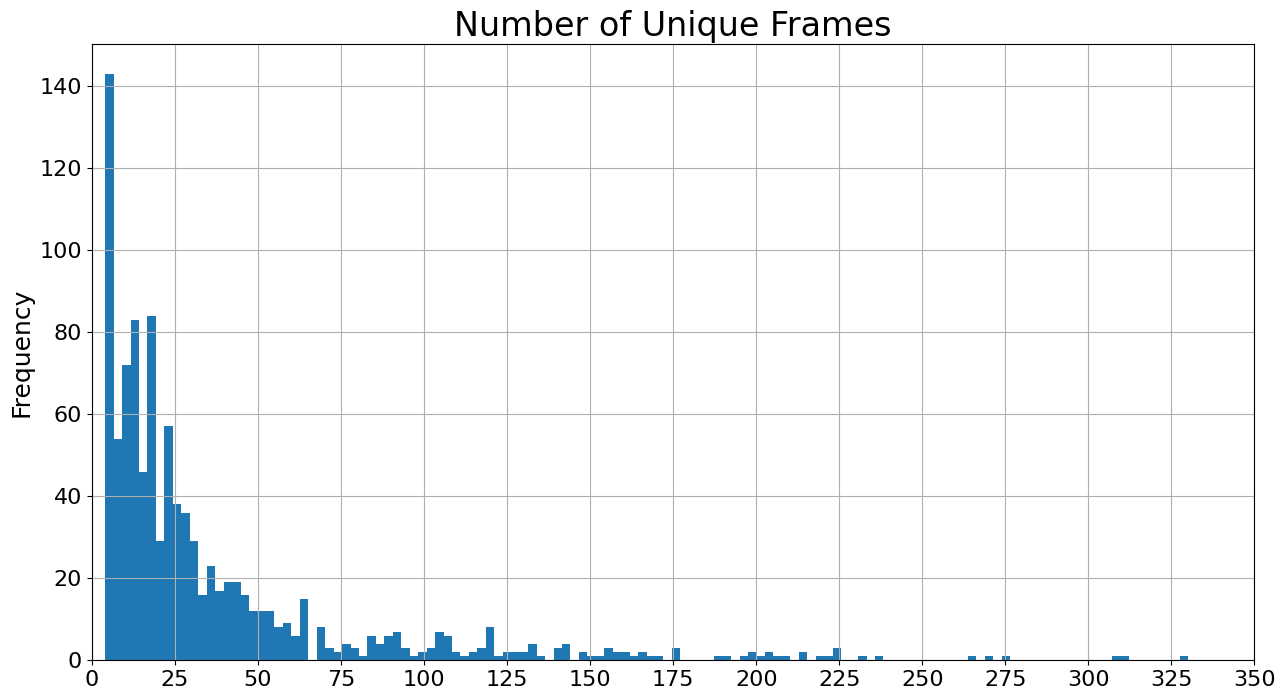

In [52]:
plt.figure(figsize=(15,8))
plt.title('Number of Unique Frames', size=24)
pd.Series(N_UNIQUE_FRAMES).plot(kind='hist', bins=128)
plt.grid()
xlim = math.ceil(plt.xlim()[1])
plt.xlim(0, xlim)
plt.xticks(np.arange(0, xlim+25, 25))
plt.show()

In [53]:
# Number of missing frames, consecutive frames with missing intermediate frame, i.e. 1,2,4,5 -> 3 is missing
display(pd.Series(N_MISSING_FRAMES).describe(percentiles=PERCENTILES).to_frame('N_MISSING_FRAMES'))

,N_MISSING_FRAMES
count,1000.000000
mean,0.001000
std,0.031623
min,0.000000
1%,0.000000
5%,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
95%,0.000000


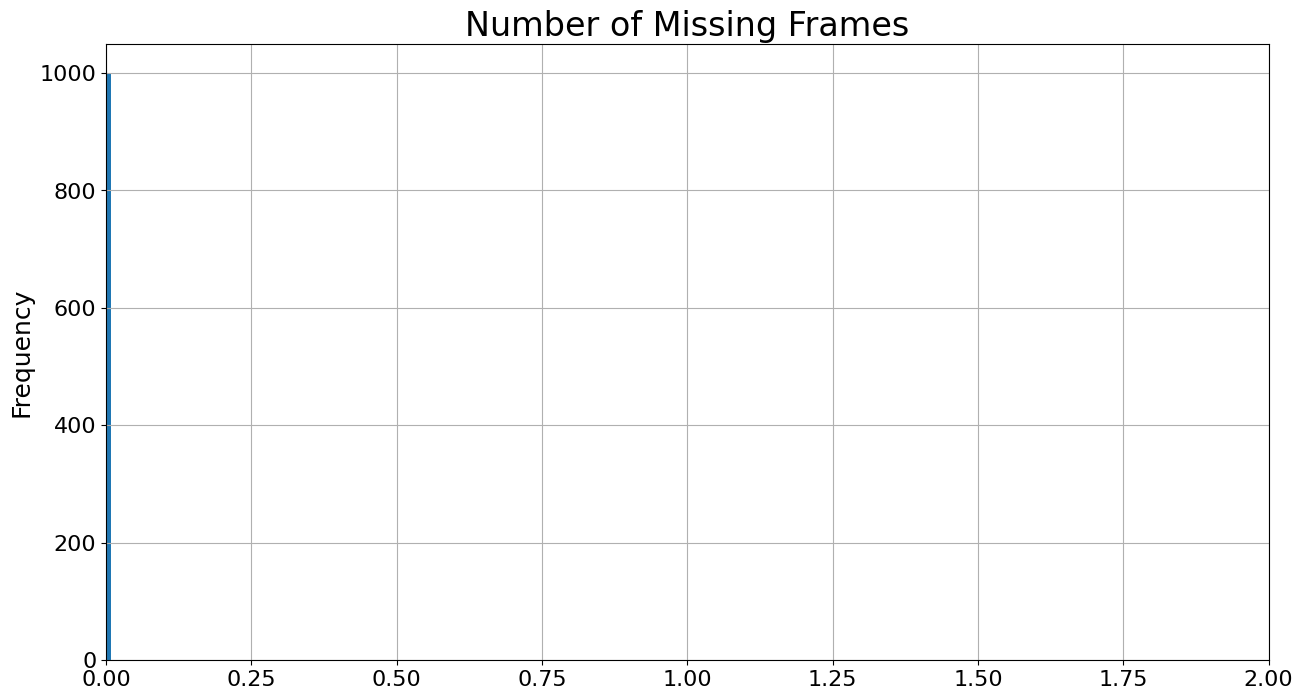

In [54]:
plt.figure(figsize=(15,8))
plt.title('Number of Missing Frames', size=24)
pd.Series(N_MISSING_FRAMES).plot(kind='hist', bins=128)
plt.grid()
plt.xlim(0, math.ceil(plt.xlim()[1]))
plt.show()

In [56]:
# Maximum frame number
display(pd.Series(MAX_FRAME).describe(percentiles=PERCENTILES).to_frame('MAX_FRAME'))


,MAX_FRAME
count,1000.000000
mean,66.761000
std,59.679222
min,3.000000
1%,12.990000
5%,22.000000
25%,33.000000
50%,42.000000
75%,61.000000
95%,203.050000


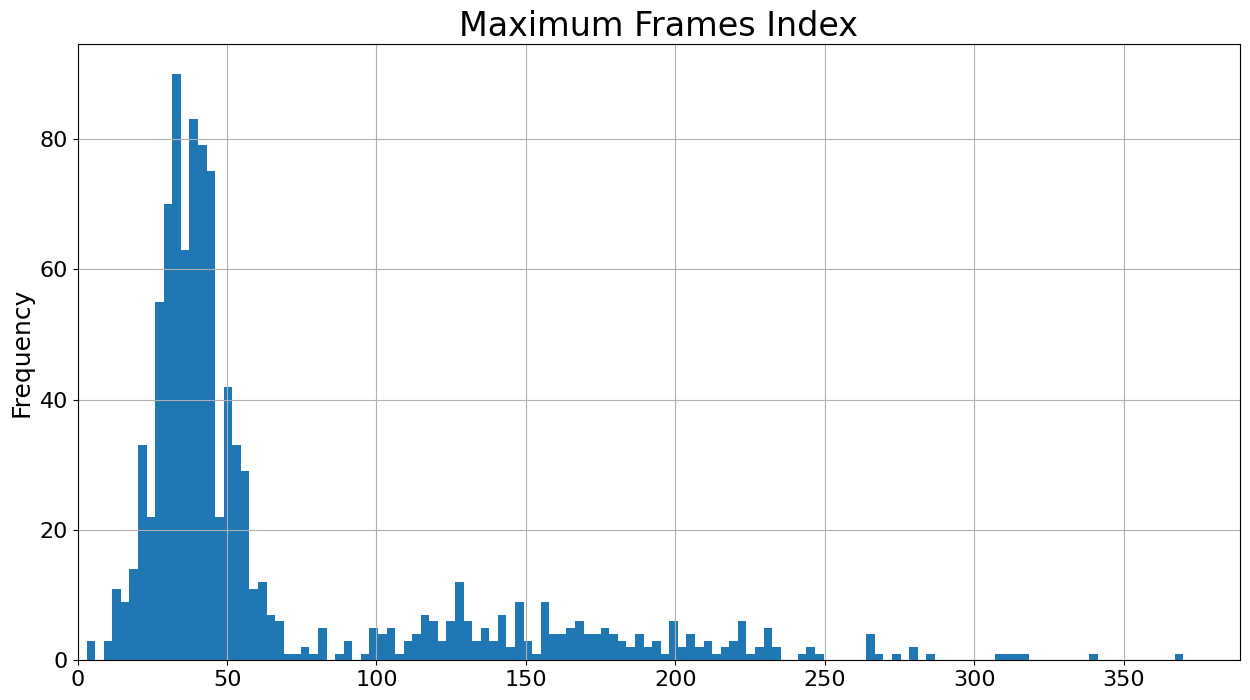

In [57]:
plt.figure(figsize=(15,8))
plt.title('Maximum Frames Index', size=24)
pd.Series(MAX_FRAME).plot(kind='hist', bins=128)
plt.grid()
plt.xlim(0, math.ceil(plt.xlim()[1]))
plt.show()

# Landmark Indices

In [58]:
USE_TYPES = ['left_hand', 'pose', 'right_hand']
START_IDX = 468
LIPS_IDXS0 = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])
# Landmark indices in original data
LEFT_HAND_IDXS0 = np.arange(468,489)
RIGHT_HAND_IDXS0 = np.arange(522,543)
LEFT_POSE_IDXS0 = np.array([502, 504, 506, 508, 510])
RIGHT_POSE_IDXS0 = np.array([503, 505, 507, 509, 511])
LANDMARK_IDXS_LEFT_DOMINANT0 = np.concatenate((LIPS_IDXS0, LEFT_HAND_IDXS0, LEFT_POSE_IDXS0))
LANDMARK_IDXS_RIGHT_DOMINANT0 = np.concatenate((LIPS_IDXS0, RIGHT_HAND_IDXS0, RIGHT_POSE_IDXS0))
HAND_IDXS0 = np.concatenate((LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0), axis=0)
N_COLS = LANDMARK_IDXS_LEFT_DOMINANT0.size
# Landmark indices in processed data
LIPS_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LIPS_IDXS0)).squeeze()
LEFT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_HAND_IDXS0)).squeeze()
RIGHT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, RIGHT_HAND_IDXS0)).squeeze()
HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, HAND_IDXS0)).squeeze()
POSE_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_POSE_IDXS0)).squeeze()

print(f'# HAND_IDXS: {len(HAND_IDXS)}, N_COLS: {N_COLS}')

# HAND_IDXS: 21, N_COLS: 66


In [59]:
LIPS_START = 0
LEFT_HAND_START = LIPS_IDXS.size
RIGHT_HAND_START = LEFT_HAND_START + LEFT_HAND_IDXS.size
POSE_START = RIGHT_HAND_START + RIGHT_HAND_IDXS.size

print(f'LIPS_START: {LIPS_START}, LEFT_HAND_START: {LEFT_HAND_START}, RIGHT_HAND_START: {RIGHT_HAND_START}, POSE_START: {POSE_START}')

LIPS_START: 0, LEFT_HAND_START: 40, RIGHT_HAND_START: 61, POSE_START: 61
